# Investigate taxonomic hotspots for medicinal plants used to treat asthma and breast cancer

### Import modules

In [1]:
import sys

sys.path.insert(0, '/Users/yojana/Documents/GitHub/ethnobotany/notebooks/PhyloCircular')

In [2]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

from io import StringIO

from ete3 import NCBITaxa

In [3]:
from matplotlib.pyplot import figure
from matplotlib.patches import Circle

from Bio import Phylo

from PhyloCircular import polar_plot
from PhyloCircular import Externals_labels, Externals_patchs, Externals_heatmap

### Load data

In [4]:
DATA_DIR = '../data/processed'

In [5]:
plant_data = pd.read_csv(f'{DATA_DIR}/plant_disease_associations.tsv.gz', sep='\t', compression='gzip')
plant_data.head(3)

,plant_curie,plant_name,disease_curie,database,evidence
0,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10067319_8
1,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10094290_4
2,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10336604_1


In [6]:
plant_disease_dict = defaultdict(set)

for row in tqdm(plant_data.values, total=plant_data.shape[0]):
    (
        plant_curie,
        plant_name,
        disease_curie,
        db,
        citation
    ) = row
    
    if '_' in citation:
        citation = citation.split('_')[0]
    plant_disease_dict[f'{plant_curie}_{disease_curie}'].add(citation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97066/97066 [00:00<00:00, 290539.10it/s]


### Flitering out plant-disease pairs with less than 6 citations

In [7]:
plant_disease_dict = {
    i: j
    for i, j in plant_disease_dict.items()
    if len(j) > 15
}
len(plant_disease_dict)

374

### Filtering out diseases connected with less than 6 plants

In [8]:
disease_plant_counter = defaultdict(set)

for plant_dis_id in tqdm(plant_disease_dict):
    plant = plant_dis_id.split('_')[0]
    disease = plant_dis_id.split('_')[1]
    disease_plant_counter[disease].add(plant)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:00<00:00, 492672.64it/s]


In [9]:
len(disease_plant_counter)

135

In [10]:
final_diseases = {
    i
    for i, j in disease_plant_counter.items()
    if len(j) > 3
}
len(final_diseases)

19

### Retaining plant-diseases passing the filter criteria

In [11]:
plant_disease_dict = {
    i: j
    for i, j in plant_disease_dict.items()
    if i.split('_')[1] in final_diseases
}
len(plant_disease_dict)

219

### Get all plants

In [12]:
all_plants = set(
    i.split('_')[0]
    for i, _ in plant_disease_dict.items()
)

all_plants = [
    i.split(':')[1]
    for i in all_plants
]

len(all_plants)

117

### Get lineage of each plant from NCBITaxon

In [13]:
ncbi = NCBITaxa()

In [14]:
plant_naming_dict = defaultdict(str)

for plant_idx in tqdm(all_plants):
    tmp_dict = ncbi.get_taxid_translator([plant_idx])
    plant_naming_dict[plant_idx] = tmp_dict[int(plant_idx)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 6449.38it/s]


### Generate Newick tree format

In [15]:
lineage_dict = defaultdict(dict)

for plant in tqdm(all_plants):
    tree = ncbi.get_lineage(plant)
    tree = [
        i
        for i in tree
        if i >= 33090 # Viridaeplante
    ]

    for idx in range(len(tree) - 1):
        
        if str(tree[idx]) in plant_naming_dict:
            parent = plant_naming_dict[str(tree[idx])].replace(' ', '_')
        else:
            parent = tree[idx]
        
        if str(tree[idx + 1]) in plant_naming_dict:
            child = plant_naming_dict[str(tree[idx + 1])].replace(' ', '_')
        else:
            child = tree[idx + 1]
                             
        lineage_dict[parent][child] = idx + 1

  0%|                                                                                                                                               | 0/117 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 32224 was translated into 2843217
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 6599.07it/s]


In [16]:
def newickify(node_to_children, root_node) -> str:
    visited_nodes = set()

    def newick_render_node(name, distance: float) -> str:
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, 0) + ';'

    # Ensure no entries in the dictionary are left unused.
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string

In [17]:
string = newickify(lineage_dict, root_node=131567)

In [18]:
biophylo_tree = Phylo.read(StringIO(string), "newick")

### Visualizing tree


### Selecting asthma as the example case

In [19]:
asthma_plant_list = plant_data[
    plant_data['disease_curie'] == 'mondo:0004979'
]['plant_curie'].unique().tolist()

asthma_plant_list = [
    i.split(':')[1]
    for i in asthma_plant_list
]

asthma_plant_list = [
    ncbi.get_taxid_translator([plant_idx])[int(plant_idx)]
    for plant_idx in tqdm(asthma_plant_list)
]

len(asthma_plant_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 11548.15it/s]


591

['Aegle_marmelos', 'Aloe_vera', 'Andrographis_paniculata', 'Angelica_sinensis', 'Astragalus_penduliflorus', 'Bacopa_monnieri', 'Boswellia_serrata', 'Centella_asiatica', 'Chelidonium_majus', 'Citrullus_colocynthis', 'Crocus_sativus', 'Cullen_corylifolium', 'Cuminum_cyminum', 'Curcuma_longa', 'Elephantopus_scaber', 'Euphorbia_hirta', 'Gastrodia_elata', 'Glycyrrhiza_glabra', 'Gynostemma_pentaphyllum', 'Hibiscus_sabdariffa', 'Hypericum_perforatum', 'Magnolia_officinalis', 'Marsdenia_tenacissima', 'Morinda_citrifolia', 'Musa_x_paradisiaca', 'Nerium_oleander', 'Nigella_sativa', 'Panax_notoginseng', 'Parietaria_judaica', 'Passiflora_incarnata', 'Platycodon_grandiflorus', 'Psidium_guajava', 'Rheum_palmatum', 'Rhodiola_rosea', 'Salvia_miltiorrhiza', 'Salvia_officinalis', 'Salvia_rosmarinus', 'Saussurea_costus', 'Scutellaria_baicalensis', 'Sophora_flavescens', 'Stephania_tetrandra', 'Tamarindus_indica', 'Tanacetum_parthenium', 'Tinospora_cordifolia', 'Tripterygium_wilfordii', 'Tussilago_farfara'

/Users/yojana/Documents/GitHub/ethnobotany/notebooks/PhyloCircular/externals.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  wedge = Wedge((0, 0), depth, min_angle, max_angle, width=vertical_cell_size,


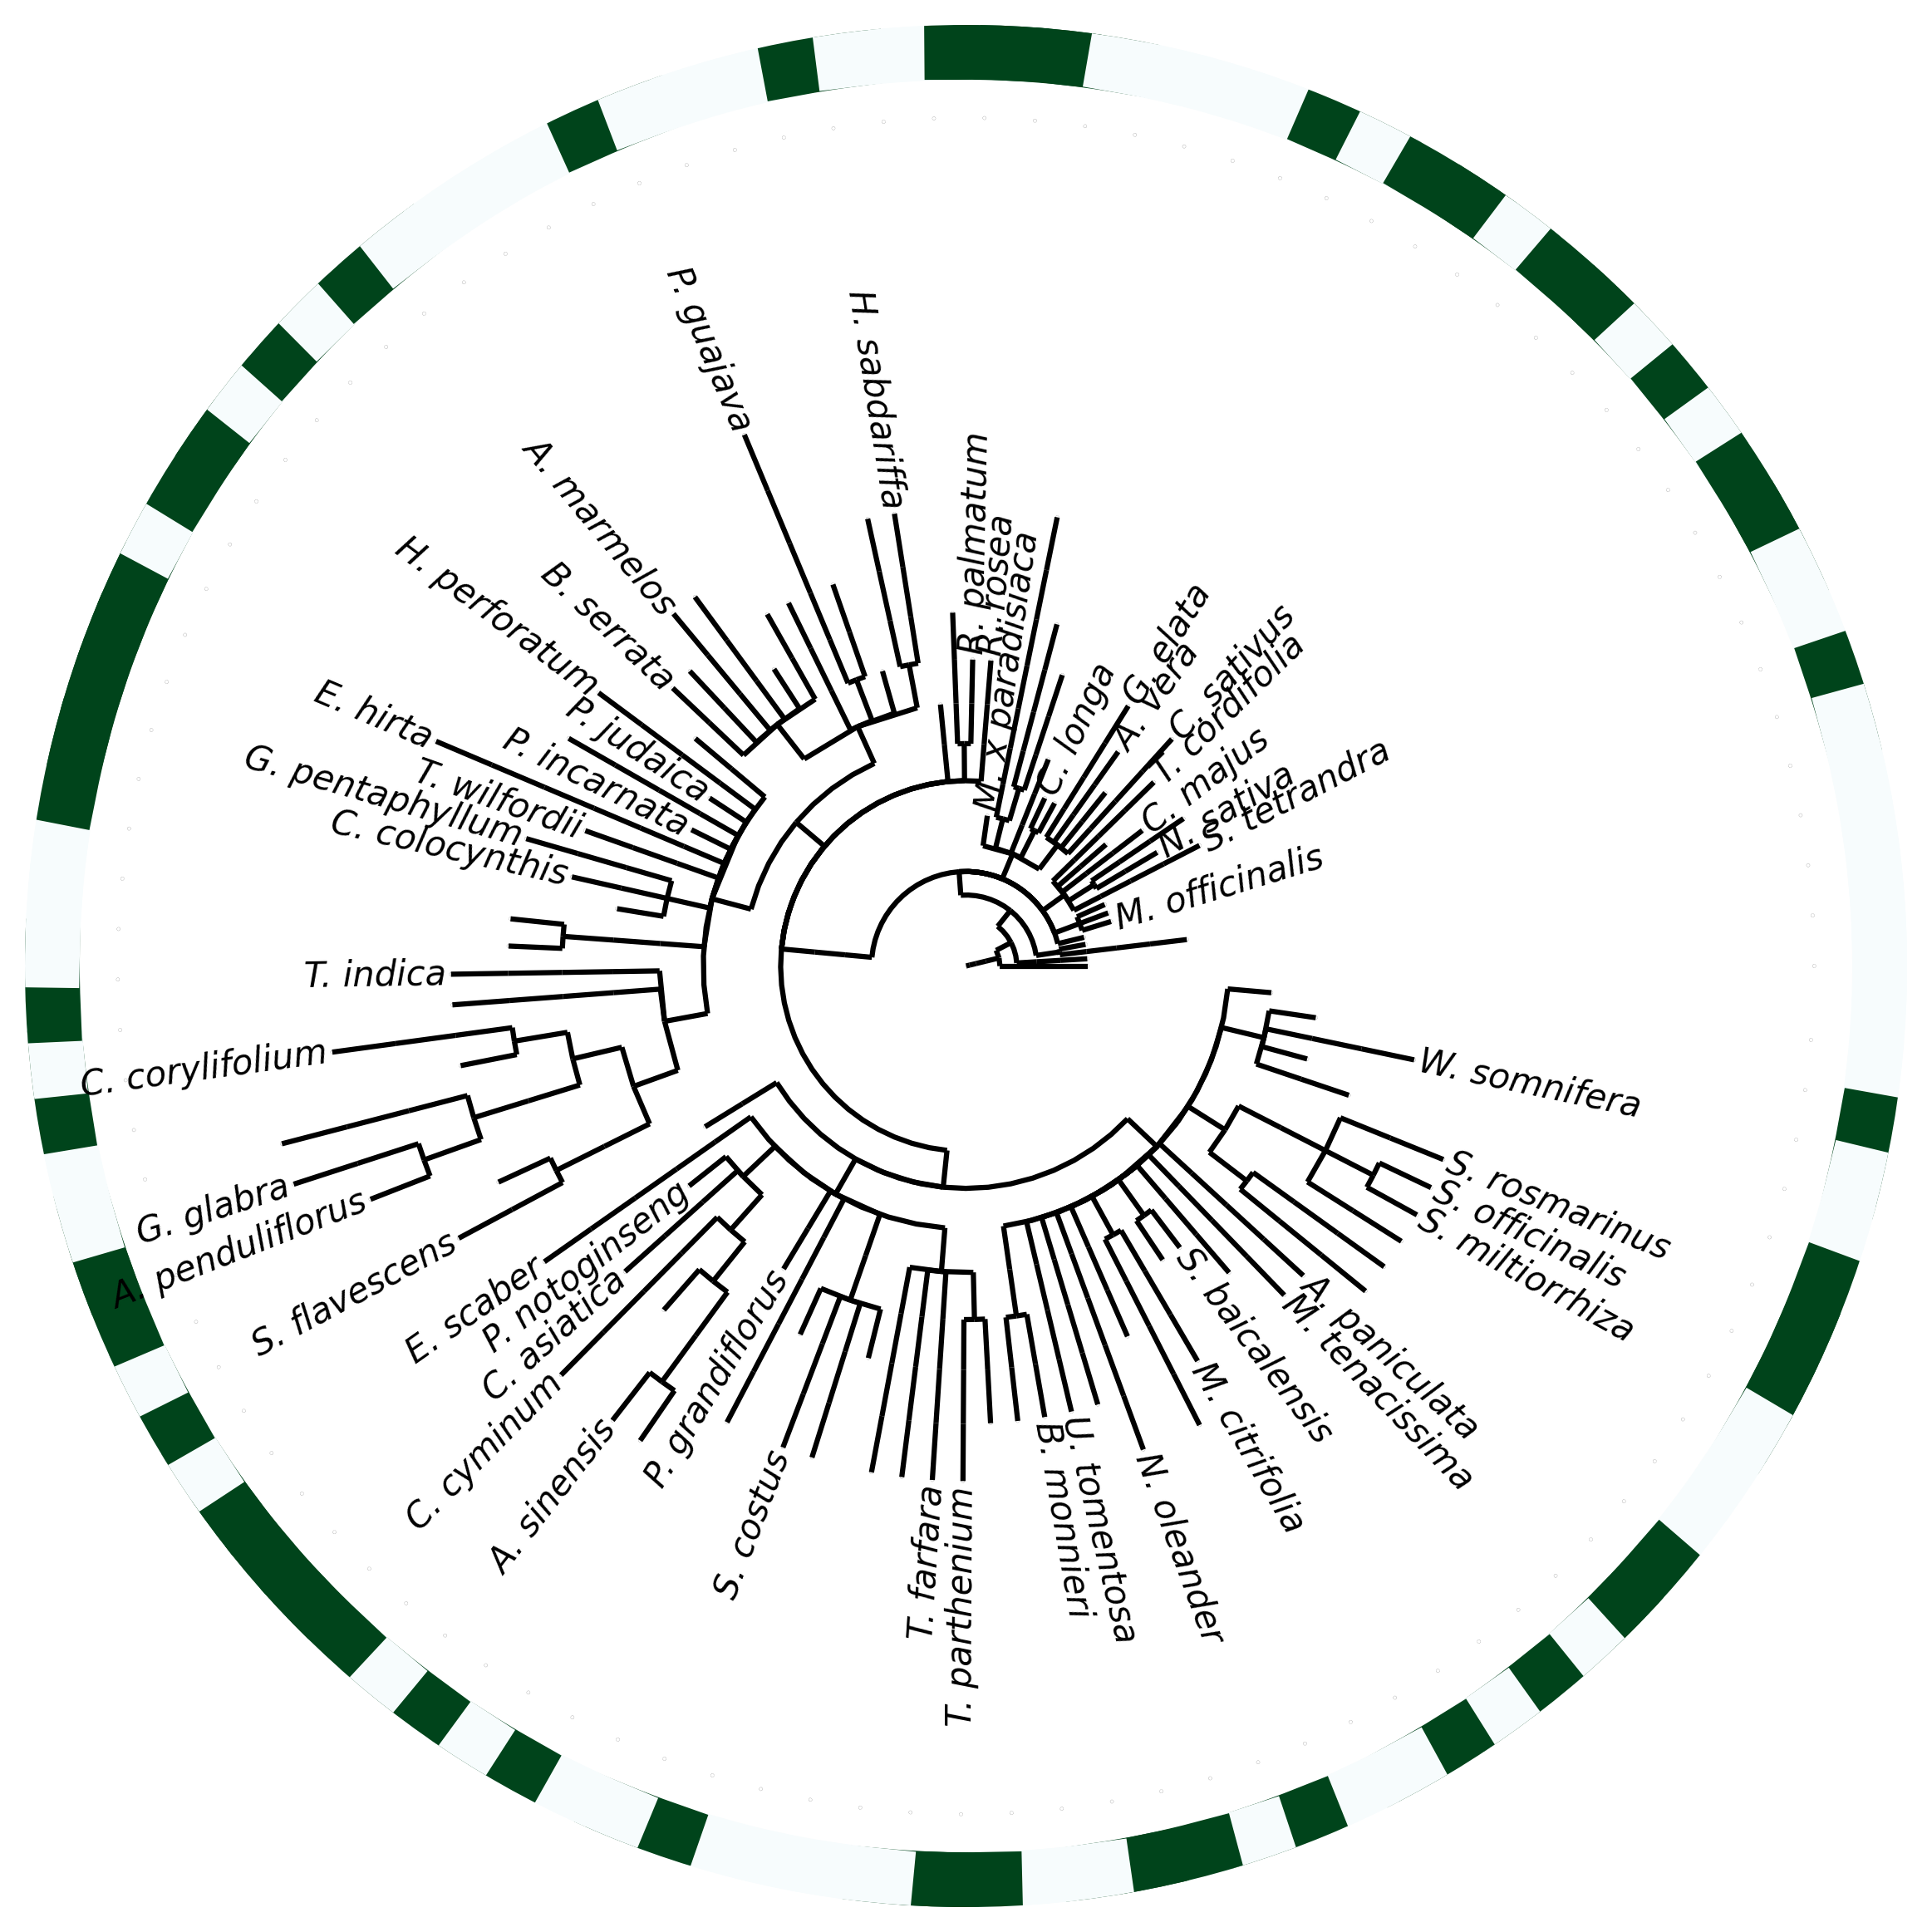

In [20]:
fig = figure(figsize=(10, 10), dpi=300)
fig.subplots_adjust(hspace = .5)


for clade in biophylo_tree.get_terminals() :
    clade.patch = lambda coordinates : Circle(coordinates, 0.01, color="black")

# heatmap data

labels = []
tp = []

hdata = {}
c = 0
for leaf in biophylo_tree.get_terminals():
    
    hdata.setdefault(leaf, {})
    
    # Get data            
    if leaf.name.replace('_', ' ') in asthma_plant_list:
        tp.append(leaf.name)
        labels.append(leaf.name)
        hdata[leaf]['Disease'] = 1
    else:
        hdata[leaf]['Disease'] = 0

# initialization and drawing
print(sorted(labels))
with open("asthma.labels_list.xt",'w') as fh:
    for label in labels:
        fh.write(label)
        
ax1 = fig.add_subplot(111, polar=True)

ep = Externals_patchs(bg_internal=True)
el = Externals_labels(size=2, bg_internal=True, offset=0.1, pad=0.01)
eh = Externals_heatmap(data=hdata, offset=0.5, size=4)
externals = [ep, el, eh]

ax1 = polar_plot(biophylo_tree, pad_label=1.5, ax=ax1, pad_wedge=0, externals=externals,
    label_leaf=labels, patch_leaf=True, wedge=False)


### Selecting breast cancer as the example case

In [21]:
cancer_plant_list = plant_data[
    plant_data['disease_curie'] == 'mondo:0021100'
]['plant_curie'].unique().tolist()

cancer_plant_list = [
    i.split(':')[1]
    for i in cancer_plant_list
]

cancer_plant_list = [
    ncbi.get_taxid_translator([plant_idx])[int(plant_idx)]
    for plant_idx in tqdm(cancer_plant_list)
]

len(cancer_plant_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 519/519 [00:00<00:00, 12157.06it/s]


519

['Actaea_racemosa', 'Aegle_marmelos', 'Aloe_vera', 'Andrographis_paniculata', 'Angelica_gigas', 'Angelica_sinensis', 'Artemisia_annua', 'Astragalus_penduliflorus', 'Azadirachta_indica', 'Bacopa_monnieri', 'Bauhinia_forficata', 'Centella_asiatica', 'Cinnamomum_aromaticum', 'Citrullus_colocynthis', 'Coptis_chinensis', 'Crocus_sativus', 'Cuminum_cyminum', 'Curcuma_longa', 'Curcuma_wenyujin', 'Cyclocarya_paliurus', 'Elephantopus_scaber', 'Garcinia_mangostana', 'Glycyrrhiza_glabra', 'Hibiscus_sabdariffa', 'Hypericum_perforatum', 'Inula_helenium', 'Isodon_rubescens', 'Lithospermum_erythrorhizon', 'Lycium_barbarum', 'Magnolia_officinalis', 'Marsdenia_tenacissima', 'Melissa_officinalis', 'Morinda_citrifolia', 'Nasturtium_officinale', 'Nerium_oleander', 'Nigella_sativa', 'Oldenlandia_diffusa', 'Panax_notoginseng', 'Paris_polyphylla', 'Platycodon_grandiflorus', 'Psidium_guajava', 'Rheum_palmatum', 'Rhodiola_rosea', 'Salvia_miltiorrhiza', 'Salvia_officinalis', 'Salvia_rosmarinus', 'Saussurea_cost

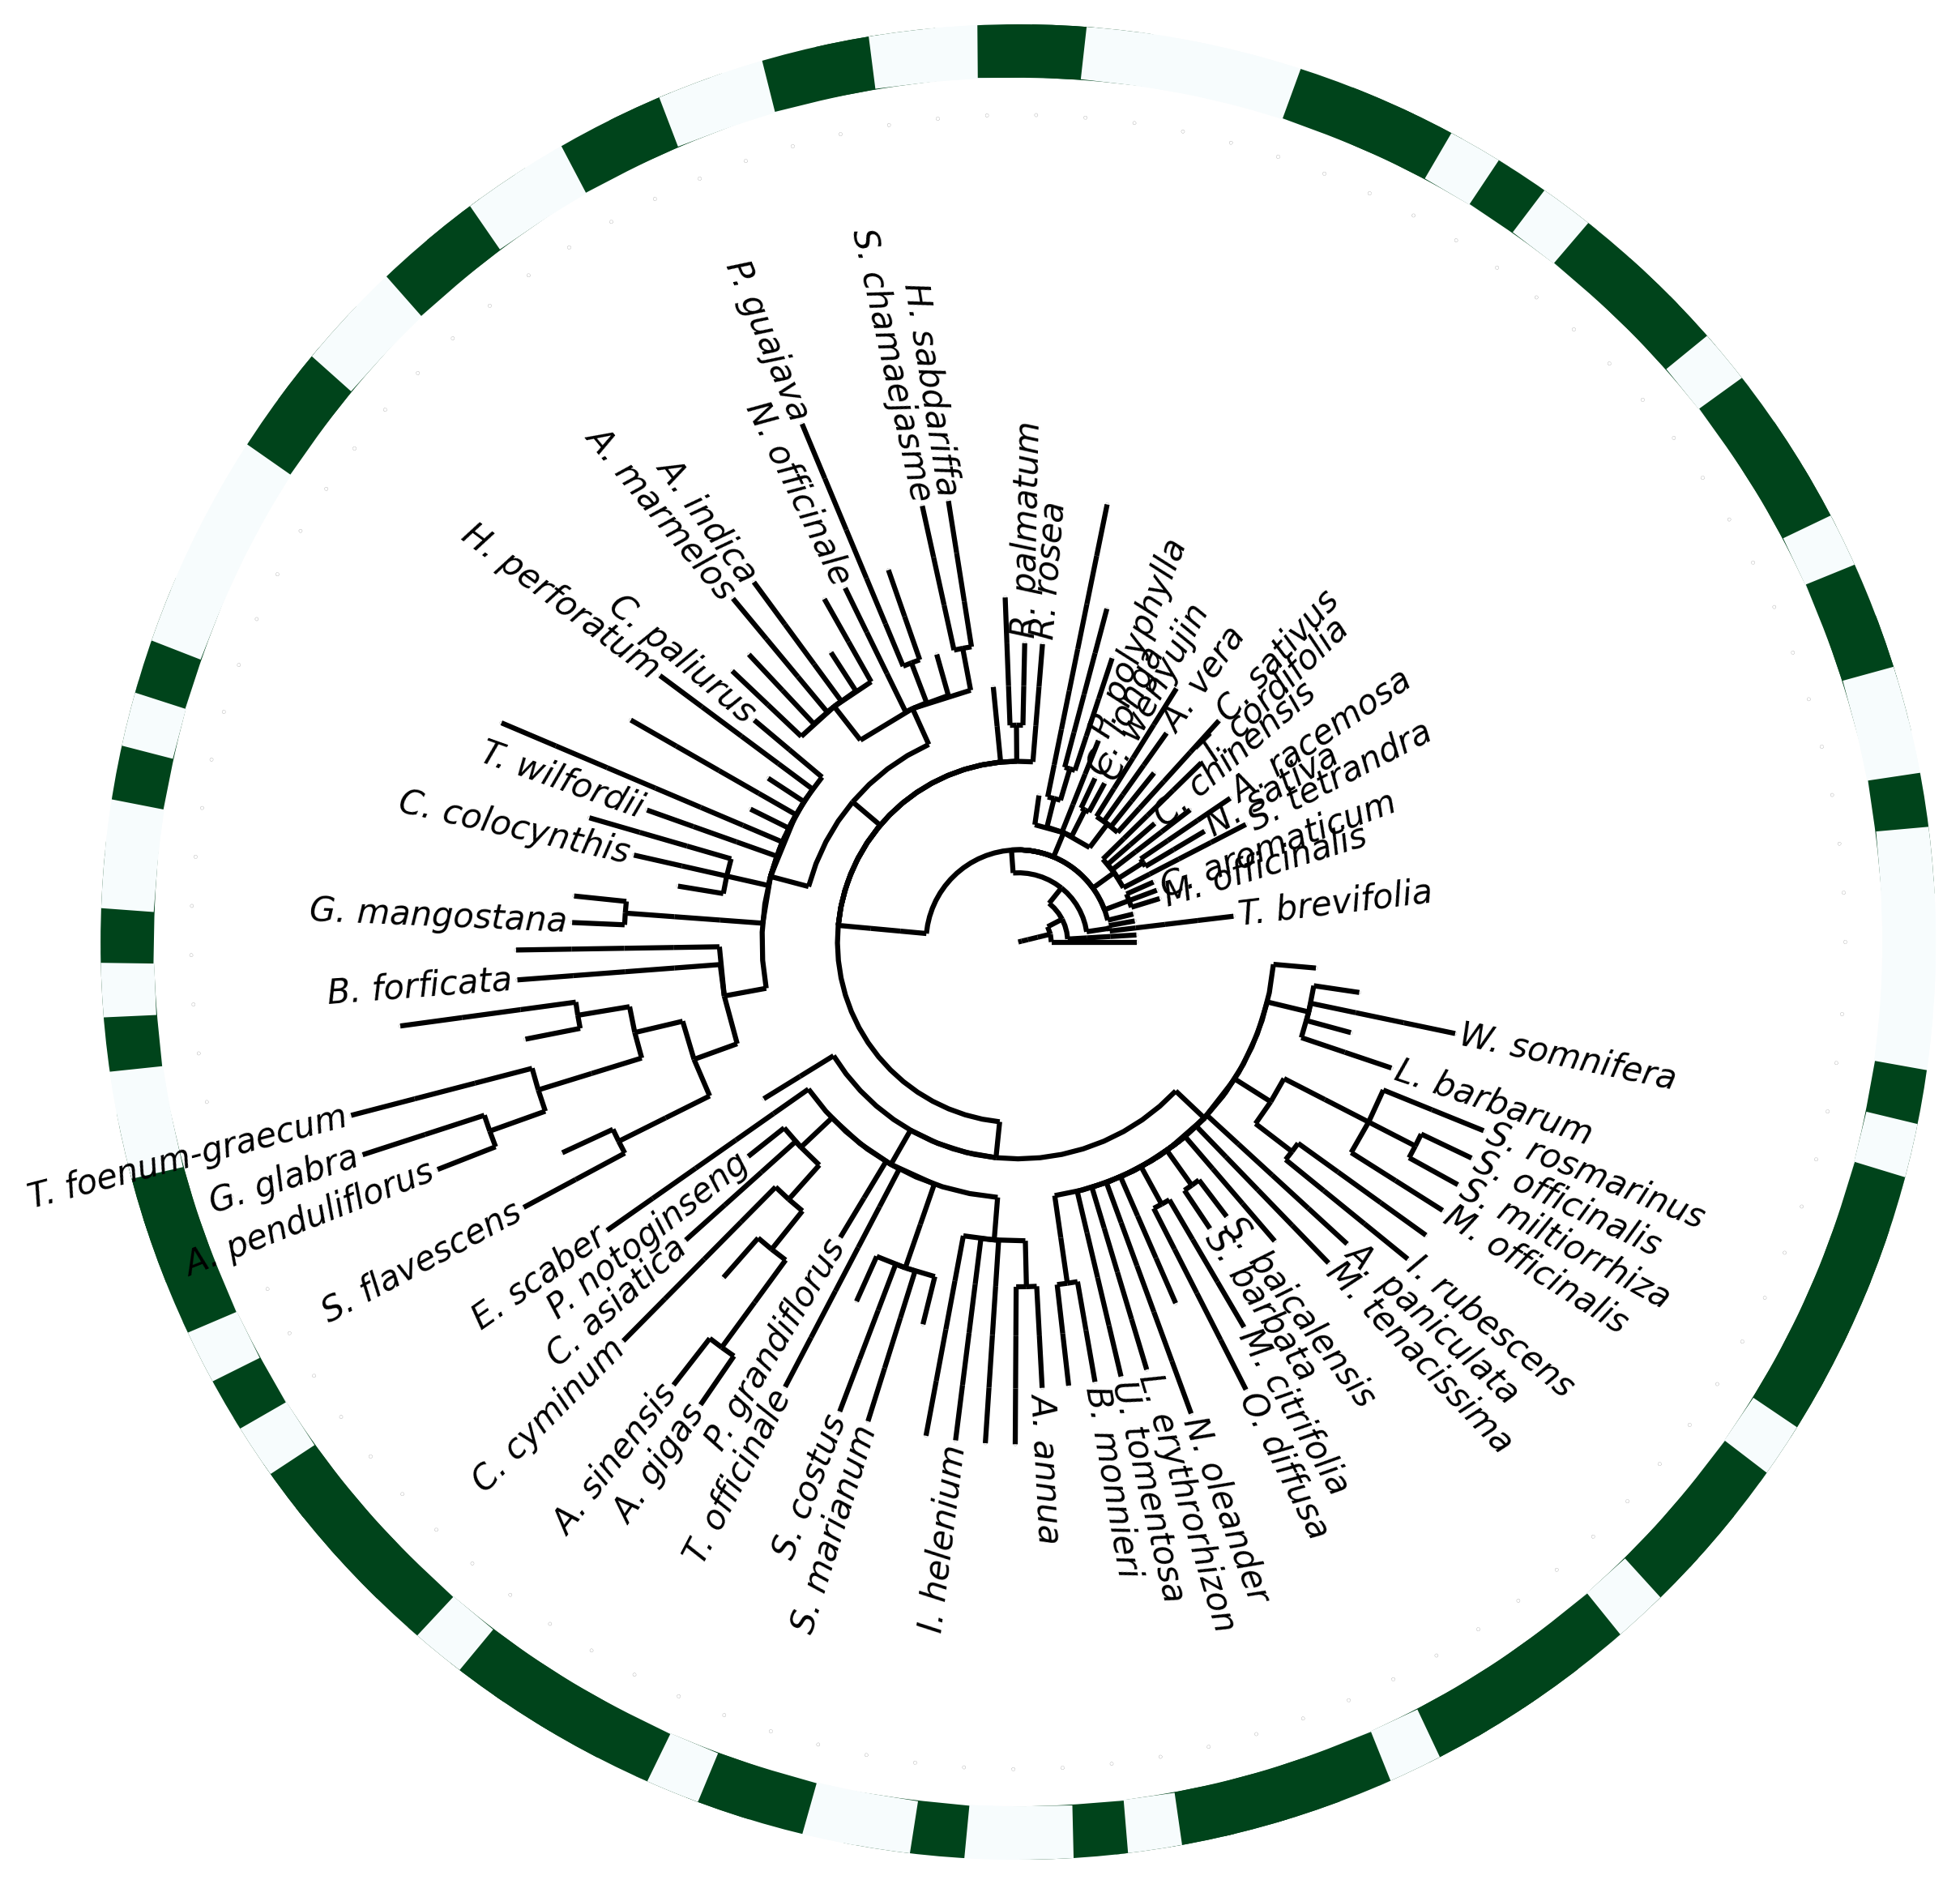

In [22]:
fig = figure(figsize=(10, 10), dpi=300)
fig.subplots_adjust(hspace = .5)


for clade in biophylo_tree.get_terminals() :
    clade.patch = lambda coordinates : Circle(coordinates, 0.01, color="black")

# heatmap data

labels = []
tp = []

hdata = {}
c = 0
for leaf in biophylo_tree.get_terminals():
    
    hdata.setdefault(leaf, {})
    
    # Get data            
    if leaf.name.replace('_', ' ') in cancer_plant_list:
        tp.append(leaf.name)
        labels.append(leaf.name)
        hdata[leaf]['Disease'] = 1
    else:
        hdata[leaf]['Disease'] = 0

# initialization and drawing
print(sorted(labels), len(labels))
with open("breast_cancer.labels_list.xt",'w') as fh:
    for label in labels:
        fh.write(label)
        
ax1 = fig.add_subplot(111, polar=True)

ep = Externals_patchs(bg_internal=True)
el = Externals_labels(size=2, bg_internal=True, offset=0.1, pad=0.01)
eh = Externals_heatmap(data=hdata, offset=0.5, size=4)
externals = [ep, el, eh]

ax1 = polar_plot(biophylo_tree, pad_label=1.5, ax=ax1, pad_wedge=0, externals=externals,
    label_leaf=labels, patch_leaf=True, wedge=False)
